# Real world example: GB1 landscape

In the previous tutorial, we have seen how to create a series of plots for the very simple case of the serine landscape that was artificially built for this purpose and had only 64 genotypes. Therefore, we knew beforehand the qualitative properties of the landscape, and saw how they were reflected on the visualization. However, we usually would want to do the opposite process, in which we visualize an unknown landscape and want to understand what are its main properties. 

In the followin tutorial we will show how to do that with a real world example using data from {cite}`Wu2016` 
for which we generated a visualization in previous work {cite}`Zhou2020c`. Now we can generate it and explore the different peaks in a few lines of python code.

As we have seen in previous notebooks, the visualizations can be easily created in few simple steps

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns

import gpmap.src.plot as plot

from gpmap.src.inference import VCregression
from gpmap.src.space import SequenceSpace
from gpmap.src.randwalk import WMWSWalk

### 1. Define sequence space

In [2]:
data = pd.read_csv('../data/gb1.data.csv', index_col=0)
space = SequenceSpace(X=data.index.values, y=data['log_binding'].values)
print(space)

Sequence Space:
	Type: protein
	Sequence length: 4
	Number of alleles per site: [20, 20, 20, 20]
	Genotypes: [AAAA,AAAC,AAAD,...,YYYV,YYYW,YYYY]
	Function y: [0.30,-2.71,-2.91,...,-3.00,-4.72,-4.88]


### 2. Define random walk on the discrete space

In [3]:
rw = WMWSWalk(space)

### 3. Calculalate visualization coordinates

In this particular case, the values are scaled so that the mean value for the WT sequences is 0. Then it seems a reasonable guess to set the mean function at stationarity at that value to choose `Ns`

In [4]:
rw.calc_visualization(mean_function=0, n_components=20)
nodes_df, edges_df = rw.nodes_df, rw.space.get_edges_df()

### 4. Plot landscape

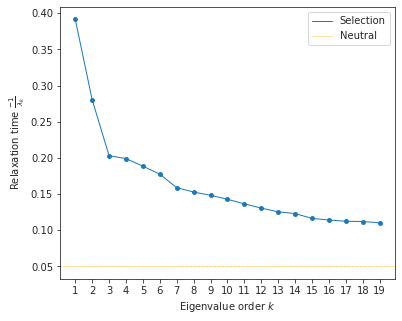

In [5]:
fig, axes = plot.init_fig(1, 1, figsize=(6, 5))
plot.plot_relaxation_times(rw.decay_rates_df, axes, neutral_time=1/rw.calc_neutral_mixing_rates())

We can clearly see that the relaxation times associated the first 2 components are substantially higher than the rest, suggesting that they should retain the most relevant features of the landscape. Still, faster decaying components still decay substantially slower than expectation at neutrality, possibly retaining other secondary sequence features.

Rendering the edges is the limiting step while plotting. Thus, for fast exploration of the landscape, it is sometimes useful skip them in the first place by not setting the `edges_df` argument, for instance, while choosing which axis to represent or the `Ns` value based on the actual visualizations and the information that they provide

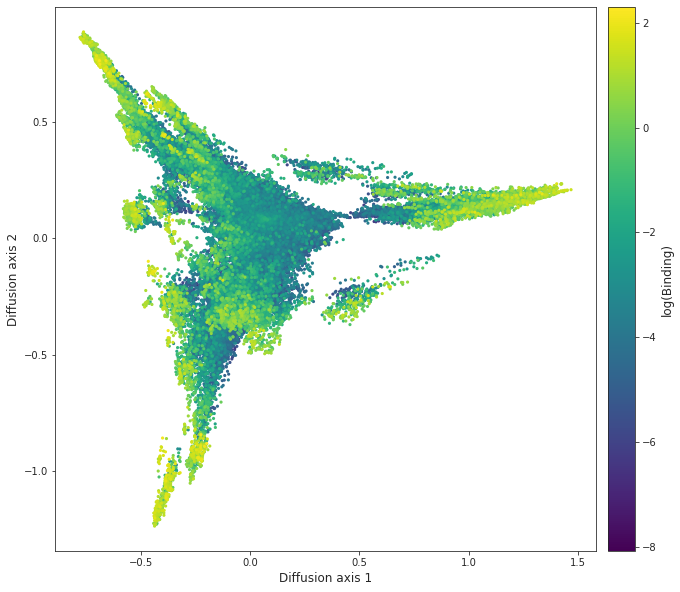

In [6]:
fig, axes = plot.init_fig(1, 1, figsize=(11, 10))
plot.plot_visualization(axes, nodes_df, #edges_df=edges_df,
                        edges_alpha=0.005, ascending=True,
                        nodes_size=10, nodes_cmap_label='log(Binding)')

The landscape seems to have 3 main fitness peaks seprated by long times to evolve from one another. Now that we have obtained a relatively reasonable visualization, we can add the edges to have a better idea about the direct connectivity among the relevant genotypes to find potential high fitness intermediates between the main peaks

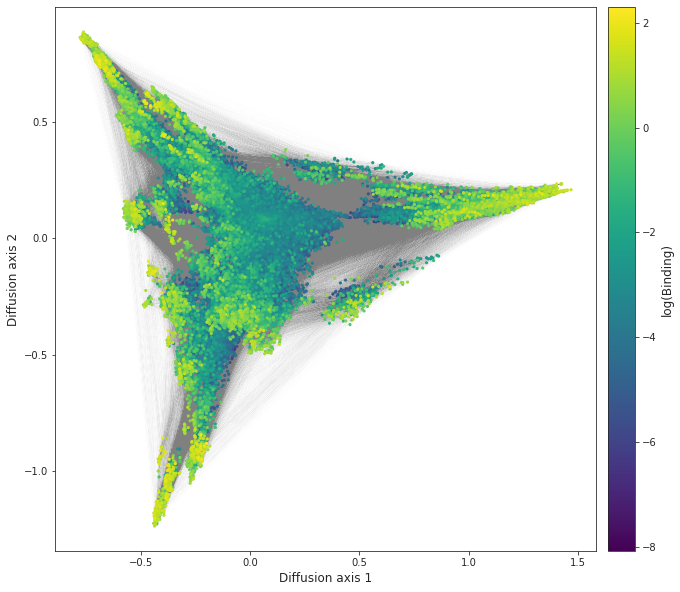

In [7]:
fig, axes = plot.init_fig(1, 1, figsize=(11, 10))
plot.plot_visualization(axes, nodes_df, edges_df=edges_df,
                        edges_alpha=0.005, ascending=True,
                        nodes_size=10, nodes_cmap_label='log(Binding)')

### Characterize the fitness peaks

Once we have a very general understanding of the main peaks in the landscape, we generally want to know what are the sequence determinants of those regions in sequence space. 

One approach to do so is to highlight the alleles at each site in the visualization using the previously shown `plot.figure_allele_grid` function. However, in protein space, it is not that useful given the large number of alleles per site. An alternative approach is to roughly select genotypes belonging to each of the peaks by hand, and plotting the corresponding sequence logos easily using `logomaker`

In [8]:
import logomaker as lm

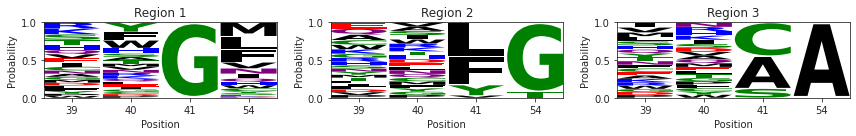

In [9]:
labels = ['39', '40', '41', '54']
peak_seqs = [nodes_df.index[nodes_df['1'] > 1],
             nodes_df.index[nodes_df['2'] > 0.6],
             nodes_df.index[nodes_df['2'] < -0.75]]

fig, subplots = plot.init_fig(1, 3, colsize=4, rowsize=2)

for i, (seqs, axes) in enumerate(zip(peak_seqs, subplots)):
    m = lm.alignment_to_matrix(seqs.values, to_type='probability', pseudocount=0)
    m.index = np.arange(m.shape[0])
    logo = lm.Logo(m, ax=axes, color_scheme='chemistry', vpad=0.05)
    axes.set(ylabel='Probability', xlabel='Position',
                     xticks=np.arange(m.shape[0]), 
                     xticklabels=labels, title='Region {}'.format(i+1))
fig.tight_layout()

This shows, not only that the first two positions barely contribute to the binding affinity in this assay, but also what are the sequence requirements at the last 2 positions for each peak. 
- The largest peak is characterized mostly by XXGX, grouping nearly 1/20 of all the possible sequences and leading to the large sequence cluster at the right hand side of the visualization. While there is a slight preference for MLF at position 54, accounting for about 50% of the sequences in the peak, we can also observe almost any other aminoacid in this set of functional sequences. 
- The other two peaks, on the other hand, are characterized by a strong requirement for a specific amoniacid at position 54, and the possibility of mostly 2 variable aminoacids at 41:
    - Region 2 requires G at 54 and F or L at 41
    - Region 3 requires A at 54 and C or A at 41
    
### Characterize the intermediates between peaks

Besides the 3 main peaks, we can observe some clusters of sequences that connect them together for every pair of peaks. These could serve as most common intermediates to evolve from one solution to another such that mutations could only happen in a very specific order while maintaining high fitness. 

Thus, it is also interesting to study the sequence determinants of those intermediates

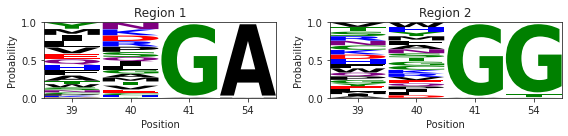

In [10]:
intermediates_seqs = [nodes_df.index[np.logical_and(nodes_df['1'] > 0.25, nodes_df['2'] < -0.25)],
                      nodes_df.index[np.logical_and(nodes_df['1'] > 0.25, nodes_df['2'] > 0.25)]]

fig, subplots = plot.init_fig(1, 2, colsize=4, rowsize=2)

for i, (seqs, axes) in enumerate(zip(intermediates_seqs, subplots)):
    m = lm.alignment_to_matrix(seqs.values, to_type='probability', pseudocount=0)
    m.index = np.arange(m.shape[0])
    logo = lm.Logo(m, ax=axes, color_scheme='chemistry', vpad=0.05)
    axes.set(ylabel='Probability', xlabel='Position',
                     xticks=np.arange(m.shape[0]), 
                     xticklabels=labels, title='Region {}'.format(i+1))
fig.tight_layout()

We can see that transitions from Region1 to regions 2 and 3 are very natural, since Region 1 is not constained at positoin 54, so it can easily take the requirements from at 54 from the other peaks without loss of fitness: XXGA and XXGG

On the other hand, regions 2 and 3 are more indirectly connected as at least 2 mutations are required to go from one peak to another. However, there seem to be a number of alternative ways in which these mutations could happen, leading to a variety of sequence clusters at high values in diffusion axis 1 that could work as intermediates between these two peaks

### Exploring more diffusion axis

We can also look into more diffusion axis to try to find more fitness peaks that are not apparent from looking at 2 dimensions alone, even if the relaxation times are shorter for the following components. Lets look at diffusion axis 3, for instance

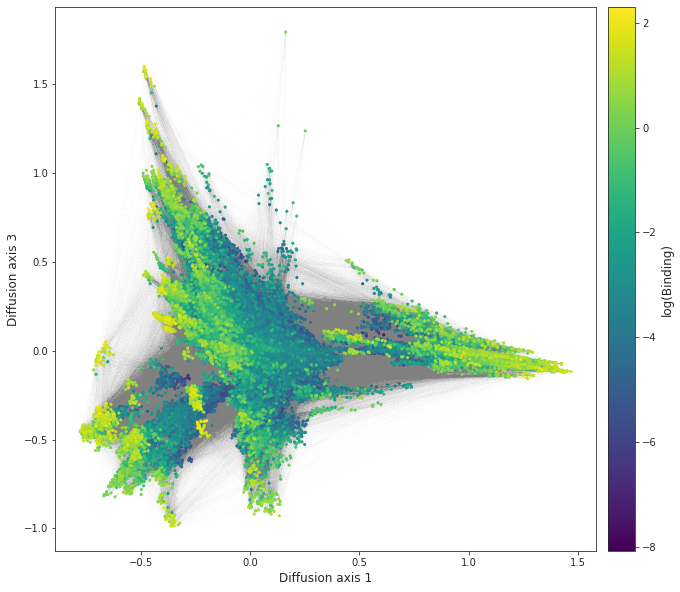

In [11]:
fig, axes = plot.init_fig(1, 1, figsize=(11, 10))
plot.plot_visualization(axes, nodes_df, edges_df=edges_df,
                        x='1', y='3',
                        edges_alpha=0.005, ascending=True,
                        nodes_size=10, nodes_cmap_label='log(Binding)')

We can see how diffusion axis 3 now separates more strongly some regions in intermediate values at diffusion axis 1, generating a more or less continuous streak of high fitness sequences for which we can characterize both ends

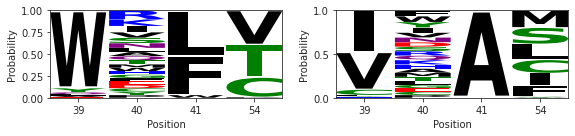

In [12]:
streak_seqs = [nodes_df.index[np.logical_and(nodes_df['1'] < 0, nodes_df['3'] > 1)],
               nodes_df.index[np.logical_and(nodes_df['1'] > -0.2, nodes_df['3'] < -0.6)]]

fig, subplots = plot.init_fig(1, 2, colsize=4, rowsize=2)

for i, (seqs, axes) in enumerate(zip(streak_seqs, subplots)):
    m = lm.alignment_to_matrix(seqs.values, to_type='probability', pseudocount=0)
    m.index = np.arange(m.shape[0])
    logo = lm.Logo(m, ax=axes, color_scheme='chemistry', vpad=0.05)
    axes.set(ylabel='Probability', xlabel='Position',
                     xticks=np.arange(m.shape[0]), 
                     xticklabels=labels)
fig.tight_layout()

- We can see that the top of the streak is characterized by a W at position 39, F/L at 41 and V, T or C at 54, while positoin 40 seems to vary quite freely. 
- The bottom of the streak is remakably different, characterized by I/V at position 49 and A at 41, while only allowing a subset of aminoacids at 54: M, S, L, C, I, F

### References

```{bibliography} gpmap_tools.bib
```
